In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
# from custom_model import LSTM_fixed_len
from custom_model import AttentionModel

from custom_dataset import customDataset
from sklearn.utils import class_weight
from pyvi import ViTokenizer
from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter
from sklearn.utils import resample,shuffle

from utils import load_checkpoint

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Load data

In [3]:
# %pwd

In [4]:
data_path = '../data'
model_path = '../model'

In [5]:
df_ = pd.read_csv(os.path.join(data_path,'question_livestream_label.csv'))

In [6]:
question = df_[df_['label']!=0]
question['label'] = [item-1 for item in list(question['label'])]
question

/Users/taindp/opt/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,content
0,0,thầy cho em hỏi nếu mình đã trúng tuyển chương...
2,0,cho em hỏi chương trình chất lượng cao ở bách ...
3,0,cho em hỏi nếu em đã trúng tuyển chương trình ...
5,1,cho em hỏi chỉ tiêu ngành khoa học máy tính nă...
8,1,cho em hỏi ngành khoa học máy tính có những hì...
...,...,...
428,2,cho em hỏi về ngành kỹ thuật hoá học và cơ hội...
429,2,cho em xin giới thiệu về ngành kỹ thuật robot ạ
430,2,ngành khoa học máy tính sau này ra làm công vi...
431,2,em muốn học tự động hoá thì tương lai sẽ có ng...


In [7]:
# def upsample(df,target_num):
class_0 = question[question['label']==0]
class_0_upsampled = resample(class_0,random_state=42,n_samples=90-len(class_0),replace=True)
question_upsampled = pd.concat([question, class_0_upsampled])

In [8]:
question_upsampled['label'].value_counts()

2    148
1    122
0     90
Name: label, dtype: int64

In [9]:
question  = question_upsampled

In [10]:
question['length'] = [len(item) for item in list(question['content'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['content'])]

In [11]:
np.mean(question['num_word'])

17.336111111111112

(array([36., 81., 77., 61., 39., 30., 25.,  5.,  3.,  3.]),
 array([ 6. ,  9.6, 13.2, 16.8, 20.4, 24. , 27.6, 31.2, 34.8, 38.4, 42. ]),
 <BarContainer object of 10 artists>)

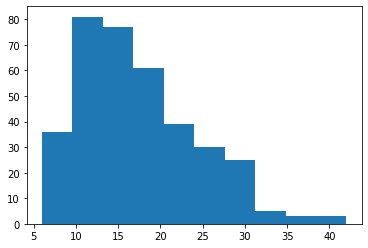

In [12]:
plt.hist(list(question['num_word']), bins = 10)

In [13]:
def tokenize(text):
    list_token = ViTokenizer.tokenize(text)
    return list_token.split(' ')

In [14]:
counts = Counter()
for index, row in question.iterrows():
    counts.update(tokenize(row['content']))

In [15]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 535
num_words after: 323


In [16]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [17]:
def encode_sentence(text, vocab2index, N=75):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
#     print(len(enc1))
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
#     print(len(encoded))
    return [encoded]
#     return encoded, length

In [18]:
N = 22
question['encoded'] = question['content'].apply(lambda x: np.array(encode_sentence(x,vocab2index,N)))
question.head()

,label,content,length,num_word,encoded
0,0,thầy cho em hỏi nếu mình đã trúng tuyển chương...,159,33,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 1..."
2,0,cho em hỏi chương trình chất lượng cao ở bách ...,106,24,"[[3, 4, 5, 10, 15, 16, 24, 25, 26, 21, 27, 28,..."
3,0,cho em hỏi nếu em đã trúng tuyển chương trình ...,148,31,"[[3, 4, 5, 6, 4, 8, 9, 10, 11, 12, 4, 13, 34, ..."
5,1,cho em hỏi chỉ tiêu ngành khoa học máy tính nă...,108,25,"[[3, 4, 5, 35, 36, 37, 38, 39, 40, 41, 42, 43,..."
8,1,cho em hỏi ngành khoa học máy tính có những hì...,70,16,"[[3, 4, 5, 36, 37, 38, 26, 46, 47, 48, 49, 23,..."


In [19]:
X = list(question['encoded'])
y = list(question['label'])

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=(1-0.693))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,random_state=42)

In [20]:
len(X_train),len(X_valid)

(270, 90)

In [21]:
# 86/16

In [22]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y).tolist(),y)
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train).tolist(),y_train)
class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights

/Users/taindp/opt/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0, 1, 2], y=[2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1, 1, 2, 0, 2, 1, 1, 2, 0, 0, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 1, 2, 1, 2, 0, 0, 1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 1, 1, 2, 0, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 1, 1, 0, 1, 0, 0, 2, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 0, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2] as keyword args. From version 1.0 (renaming of 0.25

tensor([1.3636, 0.9091, 0.8571])

In [23]:
train_ds = customDataset(X_train, y_train)
valid_ds = customDataset(X_valid, y_valid)

In [24]:
# 360*0.75

In [25]:
batch_size = 30
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
# for a,b in val_dl:
#     print(a.shape,b.shape)

In [27]:
model = AttentionModel(
                    batch_size=batch_size, 
                    output_size=class_weights.shape[0], 
                    hidden_size=128, 
                    vocab_size=vocab_size, 
                    embedding_length=400
                    )

In [28]:
model = model.train()
model.cpu()

AttentionModel(
  (word_embeddings): Embedding(325, 400)
  (lstm): LSTM(400, 128)
  (label): Linear(in_features=128, out_features=3, bias=True)
)

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [30]:
def train_one_epoch(model,train_dl,optimizer,criterion,writer,epoch):
    
    epoch_loss = 0
    epoch_acc = 0
    list_pred = []
    for x, y in train_dl:
        y = y.type(torch.int64)
        x = x.long()

        y_pred = model(x)

        optimizer.zero_grad()


        loss = criterion(y_pred,y)
        
        writer.add_scalar("Loss/train", loss, epoch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        list_pred.append(y_pred.argmax())
    return epoch_loss / len(train_dl)

In [31]:
def evaluate_one_epoch(model, valid_dl,criterion,writer,epoch):
    model.eval()
    epoch_acc = 0
    epoch_loss = 0
    list_true = []
    list_pred = []
    with torch.no_grad():
        for x, y in valid_dl:
            y = y.type(torch.int64)
            x = x.long()
            y_hat = model(x)
#             acc = binary_accuracy(y_hat,y)
            loss = criterion(y_hat,y)
            writer.add_scalar("Loss/valid", loss, epoch)
            epoch_loss += loss.item()

    return epoch_loss/len(valid_dl)

In [32]:

loss=[]
acc=[]
val_loss=[]
acc_max = 0

valid_loss_min = 1.

for epoch in range(30):
    
    train_loss = train_one_epoch(model,train_dl,optimizer,criterion,writer,epoch)
    valid_loss = evaluate_one_epoch(model, val_dl,criterion,writer,epoch)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

    print(f'\tTrain Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')
    
    if valid_loss < valid_loss_min:
        valis_loss_min = valid_loss
        checkpoint = {'model': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}
#         valis_loss_save = str(valis_loss_min).replace('.','_')[:10]
        torch.save(checkpoint, os.path.join(model_path,'checkpoint_{}.pth'.format(valis_loss_min)))

    exp_lr_scheduler.step()
    
writer.flush()
writer.close()

Epoch-0 lr: 0.001
	Train Loss: 1.138 | Valid Loss: 1.118
Epoch-1 lr: 0.001
	Train Loss: 1.073 | Valid Loss: 1.067
Epoch-2 lr: 0.001
	Train Loss: 1.046 | Valid Loss: 1.055
Epoch-3 lr: 0.001
	Train Loss: 0.985 | Valid Loss: 1.000
Epoch-4 lr: 0.001
	Train Loss: 0.873 | Valid Loss: 0.893
Epoch-5 lr: 0.0008
	Train Loss: 0.673 | Valid Loss: 0.657
Epoch-6 lr: 0.0008
	Train Loss: 0.404 | Valid Loss: 0.446
Epoch-7 lr: 0.0008
	Train Loss: 0.193 | Valid Loss: 0.384
Epoch-8 lr: 0.0008
	Train Loss: 0.069 | Valid Loss: 0.392
Epoch-9 lr: 0.0008
	Train Loss: 0.036 | Valid Loss: 0.457
Epoch-10 lr: 0.00064
	Train Loss: 0.020 | Valid Loss: 0.570
Epoch-11 lr: 0.00064
	Train Loss: 0.015 | Valid Loss: 0.648
Epoch-12 lr: 0.00064
	Train Loss: 0.008 | Valid Loss: 0.678
Epoch-13 lr: 0.00064
	Train Loss: 0.005 | Valid Loss: 0.714
Epoch-14 lr: 0.00064
	Train Loss: 0.004 | Valid Loss: 0.752
Epoch-15 lr: 0.0005120000000000001
	Train Loss: 0.003 | Valid Loss: 0.785
Epoch-16 lr: 0.0005120000000000001
	Train Loss: 0.0

In [33]:
# stop = 

In [34]:
# checkpoint = {'model': model_fixed,
#       'state_dict': model_fixed.state_dict(),
#       'optimizer' : optimizer.state_dict()}

# torch.save(checkpoint, os.path.join(model_path,'model_jun24.pth'))

In [55]:
load_model = load_checkpoint(os.path.join(model_path,'checkpoint_0.38374345004558563.pth'))

In [56]:
list_pred = []
list_true = []
for x,y in val_dl:
    x = x.long()
#     print(x.shape)
    pred = load_model(x)
    for item in pred:
#         print(item.argmax())
        list_pred.append(item.argmax().item())
    for true in y:
        list_true.append(true.item())
#         print(true.item())

In [57]:
print(classification_report(list_pred,list_true))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.96      1.00      0.98        22
           2       0.88      0.88      0.88        43

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89      0.89      0.89        90



In [70]:
confusion_matrix(list_pred,list_true)

array([[20,  0,  5],
       [ 0, 22,  0],
       [ 4,  1, 38]])

In [73]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

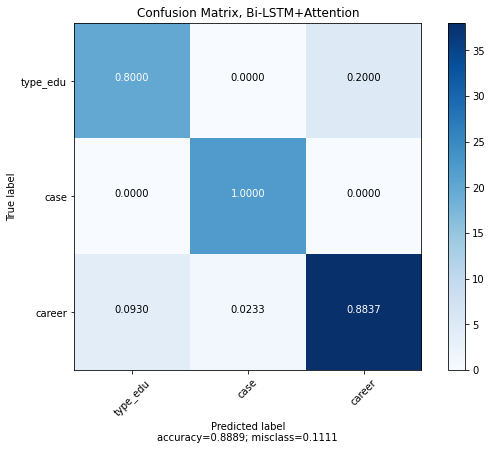

In [74]:
# from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(list_pred,list_true),
                      normalize    = True,
                      target_names = ['type_edu', 'case', 'career'],
                      title        = "Confusion Matrix, Bi-LSTM+Attention")

In [69]:
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# array = confusion_matrix(list_pred,list_true).tolist()
# array_trans = np.transpose(array)
# # df_cm = pd.DataFrame(array, index = [i for i in ['type_edu','case','career']],
# #                   columns = [i for i in ['type_edu','case','career']])
# plt.figure(figsize = (10,7))
# sn.heatmap(array/np.sum(array), cmap='Blues',vmin=0, vmax=1)

In [41]:
np.average(f1_score(list_true, list_pred, average=None))

0.8700416600748827

In [42]:
248/3

82.66666666666667

# Test

In [43]:
# load_model

In [44]:
# filename = os.path.join(model_path,'model_intent.pth')
# joblib.dump(load_model, filename)
# # with open('vectorizer.pickle', 'wb') as handle:
# #     pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
# import requests
# url = 'https://api-intent.herokuapp.com/predict'
# pred = requests.post(url,json={'message':'ad cho em hỏi chương trình tiên tiến với chất lượng cao khác nhau thế nào ạ'})
# print(pred.json())


In [46]:
# for x,y in val_dl:
#     print(x.shape)

In [47]:
# vocab2index

In [48]:
torch.save(vocab2index,os.path.join(model_path,'vocab_12jul.pth'))

In [49]:
vocab2index = torch.load(os.path.join(model_path,'vocab_12jul.pth'))

In [50]:
N

22

In [51]:
pad_enc = torch.zeros([29,22])
# pad_enc.shape

In [52]:
test_sent = 'ad cho em hỏi ngành điện tử viễn thông có ổn không ạ'
test_enc =  torch.from_numpy(encode_sentence(test_sent, vocab2index, N)[0].astype(np.float32))
test_enc = torch.reshape(test_enc,(1,N))
test_enc

tensor([[280.,   3.,   4.,   5.,  36.,  68., 153.,  26.,   1.,  22.,  23.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [53]:
test_enc_pad = torch.cat([test_enc,pad_enc])
test_enc_pad.shape

torch.Size([30, 22])

In [54]:

preds = load_model(test_enc_pad.long())
prop_preds = nn.functional.softmax(preds,dim=1)
print(prop_preds[0])
pred_label = prop_preds.argmax().item()
pred_label

tensor([0.1806, 0.0717, 0.7477])


2